# Text Classification using TF-IDF and SGDClassifier

This notebook demonstrates text classification using:
1.  **Feature Engineering**: TF-IDF (Term Frequency-Inverse Document Frequency).
2.  **Classification Algorithm**: SGDClassifier (Stochastic Gradient Descent), which is efficient for large-scale learning and often used for text classification (linear SVM or logistic regression).

Target Label: `Label`
Content: `Cleaned_Content`

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure reproducible results
np.random.seed(42)

In [ ]:
# Load the dataset
file_path = '../cleaned_data.csv'
data = pd.read_csv(file_path)

# Drop rows with missing values
data = data.dropna(subset=['Label', 'Cleaned_Content'])

# Display the first few rows
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_data.csv'

In [ ]:
# Initialize TF-IDF Vectorizer
# max_features: Limit the vocabulary size to top N most frequent words
# ngram_range: Include unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the 'Cleaned_Content' column
X = tfidf_vectorizer.fit_transform(data['Cleaned_Content'])
y = data['Label']

print("Shape of TF-IDF matrix:", X.shape)

Shape of TF-IDF matrix: (1641, 5000)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 1312
Testing set size: 329


In [ ]:
# Initialize SGD Classifier
# loss='hinge' gives a linear SVM
# penalty='l2' is the standard regularizer for linear SVM models
# max_iter=1000 is the maximum number of passes over the training data
sgd_classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=1000, tol=1e-3)

# Train the classifier
sgd_classifier.fit(X_train, y_train)

print("SGD Model training completed.")

SGD Model training completed.


In [ ]:
# Make predictions
y_pred = sgd_classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6930

Classification Report:
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.71      0.70      0.71        71
Frontotemporal Dementia       0.88      0.73      0.79        77
     Lewy Body Dementia       0.57      0.57      0.57        60
    Parkinson's Disease       0.62      0.73      0.67        59
      Vascular Dementia       0.68      0.73      0.70        62

               accuracy                           0.69       329
              macro avg       0.69      0.69      0.69       329
           weighted avg       0.70      0.69      0.70       329



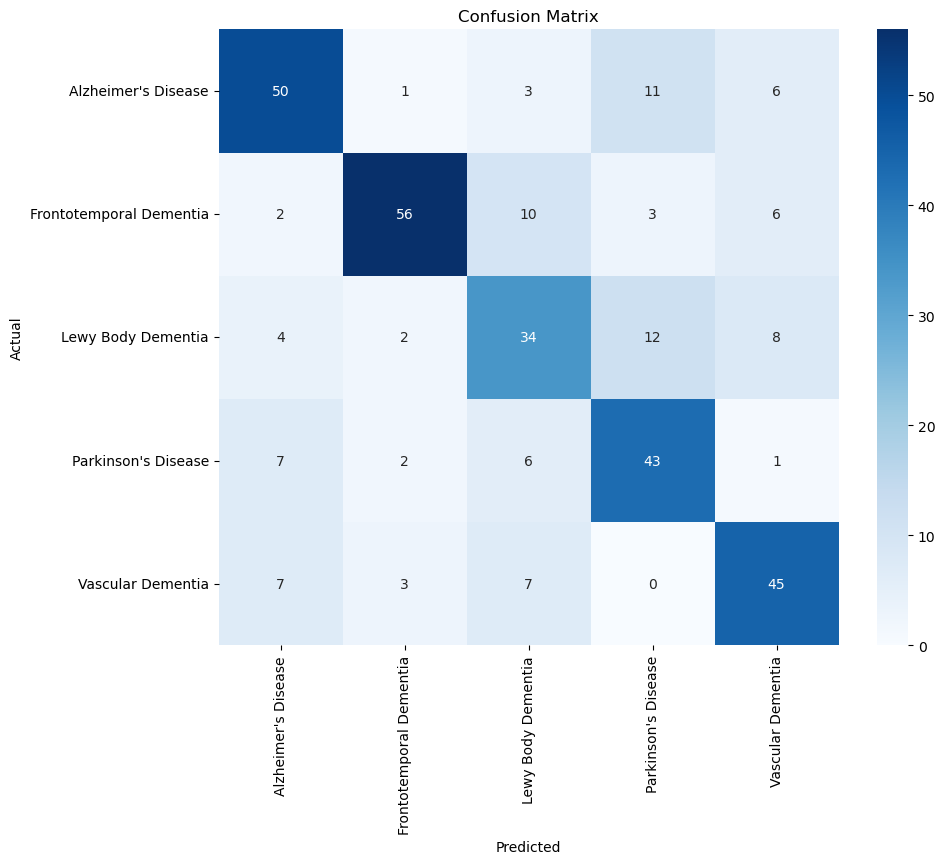

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sgd_classifier.classes_, yticklabels=sgd_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()